In [5]:
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import warnings
import logging
import time

from src.datasets import CSVDataset
from src.methods.DMF import DMFImputer
from src.methods.DCAE import DCAEImputer

warnings.filterwarnings('ignore')
logging.getLogger("pytorch_lightning").setLevel(logging.INFO)

pl.seed_everything(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_dir = Path("./data")
csv_files = list(data_dir.glob("*.csv"))

Seed set to 0


In [6]:
def load_impute_methods():
    methods = []
    methods_dir = Path("./src/methods")
    
    for impute_file in methods_dir.glob("*_impute.py"):
        method_name = impute_file.stem.replace("_impute", "").upper()
        try:
            import importlib.util
            spec = importlib.util.spec_from_file_location(method_name, impute_file)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            
            if hasattr(module, 'impute'):
                methods.append((method_name, module.impute))
                print(f"Loaded: {method_name}")
        except Exception as e:
            print(f"Failed to load {method_name}: {e}")
    
    return methods

def train_jingwei(model_name, data_normalized, mask, max_epochs=100):
    common_params = {
        'full_data_tensor': data_normalized,
        'full_mask_tensor': mask,
        'batch_size': 1024,
    }
    
    if model_name == 'DMF':
        model = DMFImputer(
            **common_params,
            embedding_dim=64,
            hidden_dims=[256, 128],
            reconstruction_weight=1.0,
            mask_weight=0.5,
            lr=5e-4,
        )
    elif model_name == 'DCAE':
        model = DCAEImputer(
            **common_params,
            ae_dim=256,
            mask_predictor_hidden_dim=128,
            lambda_mask=0.5,
            num_encoder_blocks=3,
            num_decoder_blocks=3,
            dilation=3,
            learning_rate=5e-5,
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='cuda',
        devices=1,
        enable_checkpointing=False,
        enable_model_summary=True,     
        enable_progress_bar=True,      
        log_every_n_steps=1,          
    )
    
    
    trainer.fit(model)
    model.eval()
    
    with torch.no_grad():
        imputed_normalized = model.get_imputed_data()
    
    return imputed_normalized

Loaded: MISSFOREST
Loaded: VAE
Loaded: KNN
Loaded: NMF
Loaded: DAE
Loaded: MIN
Loaded: MICE

Evaluating: Alzheimer
Data shape: (210, 1541)
Initial observed: 254968
Dynamic masked: 229546
Training observed: 25422.0


Traditional methods:   0%|          | 0/7 [00:00<?, ?it/s]

  MISSFOREST: Warning - 20 all-zero columns detected


Traditional methods:  14%|█▍        | 1/7 [39:51<3:59:11, 2391.91s/it]

  MISSFOREST: MSE=6.07e-01, time=2391.88s
  VAE: Warning - 20 all-zero columns detected


epoch,train_loss,valid_loss,time
0,195.280533,None,00:00
1,194.948532,None,00:00
2,194.494049,None,00:00
3,194.073730,None,00:00
4,193.748871,None,00:00
5,192.873093,None,00:00
6,192.358795,None,00:00
7,191.815338,None,00:00
8,191.382629,None,00:00
9,190.624191,None,00:00


Traditional methods:  29%|██▊       | 2/7 [40:37<1:24:18, 1011.63s/it]

  VAE: MSE=6.13e-01, time=45.42s
  KNN: Warning - 20 all-zero columns detected


Traditional methods:  43%|████▎     | 3/7 [40:37<36:39, 550.00s/it]   

  KNN: MSE=6.74e-01, time=0.63s
  NMF: Warning - 20 all-zero columns detected


Traditional methods:  57%|█████▋    | 4/7 [40:38<16:38, 332.96s/it]

  NMF: MSE=2.51e+02, time=0.23s
  DAE: Warning - 20 all-zero columns detected


epoch,train_loss,valid_loss,time
0,1414.848999,None,00:00
1,1395.927002,None,00:00
2,1375.764893,None,00:00
3,1353.542847,None,00:00
4,1328.509766,None,00:00
5,1300.334839,None,00:00
6,1268.549194,None,00:00
7,1235.258789,None,00:00
8,1200.406006,None,00:00
9,1163.530762,None,00:00


Traditional methods:  71%|███████▏  | 5/7 [41:10<07:29, 224.59s/it]

  DAE: MSE=6.40e-01, time=32.42s
  MIN: Warning - 20 all-zero columns detected
  MIN: MSE=2.74e+00, time=0.03s
  MICE: Warning - 20 all-zero columns detected


Traditional methods: 100%|██████████| 7/7 [51:10<00:00, 438.58s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | DMF  | 1.1 M  | train
---------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.402     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


  MICE: MSE=8.16e-01, time=599.29s

Training DMF...
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, v_num=13, train/loss_step=1.160, train/loss_epoch=1.160]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, v_num=13, train/loss_step=1.160, train/loss_epoch=1.160]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | DCAE | 719 K  | train
---------------------------------------
719 K     Trainable params
0         Non-trainable params
719 K     Total params
2.879     Total estimated model params size (MB)
137       Modules in train mode
0         Modules in eval mode


  DMF: MSE=5.95e-01, time=14.01s, zero_cols=20

Training DCAE...
Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s, v_num=14]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  9.21it/s, v_num=14]
  DCAE: MSE=1.20e+00, time=6.45s, zero_cols=20

BENCHMARK RESULTS


,dataset,method,MSE,time_s,zero_cols
0,Alzheimer,MISSFOREST,0.607,"2,391.879",20
1,Alzheimer,VAE,0.613,45.421,20
2,Alzheimer,KNN,0.674,0.634,20
3,Alzheimer,NMF,250.693,0.227,20
4,Alzheimer,DAE,0.640,32.420,20
5,Alzheimer,MIN,2.738,0.026,20
6,Alzheimer,MICE,0.816,599.286,20
7,Alzheimer,DMF,0.595,14.010,20
8,Alzheimer,DCAE,1.200,6.450,20



Results saved to benchmark_results_detailed.csv


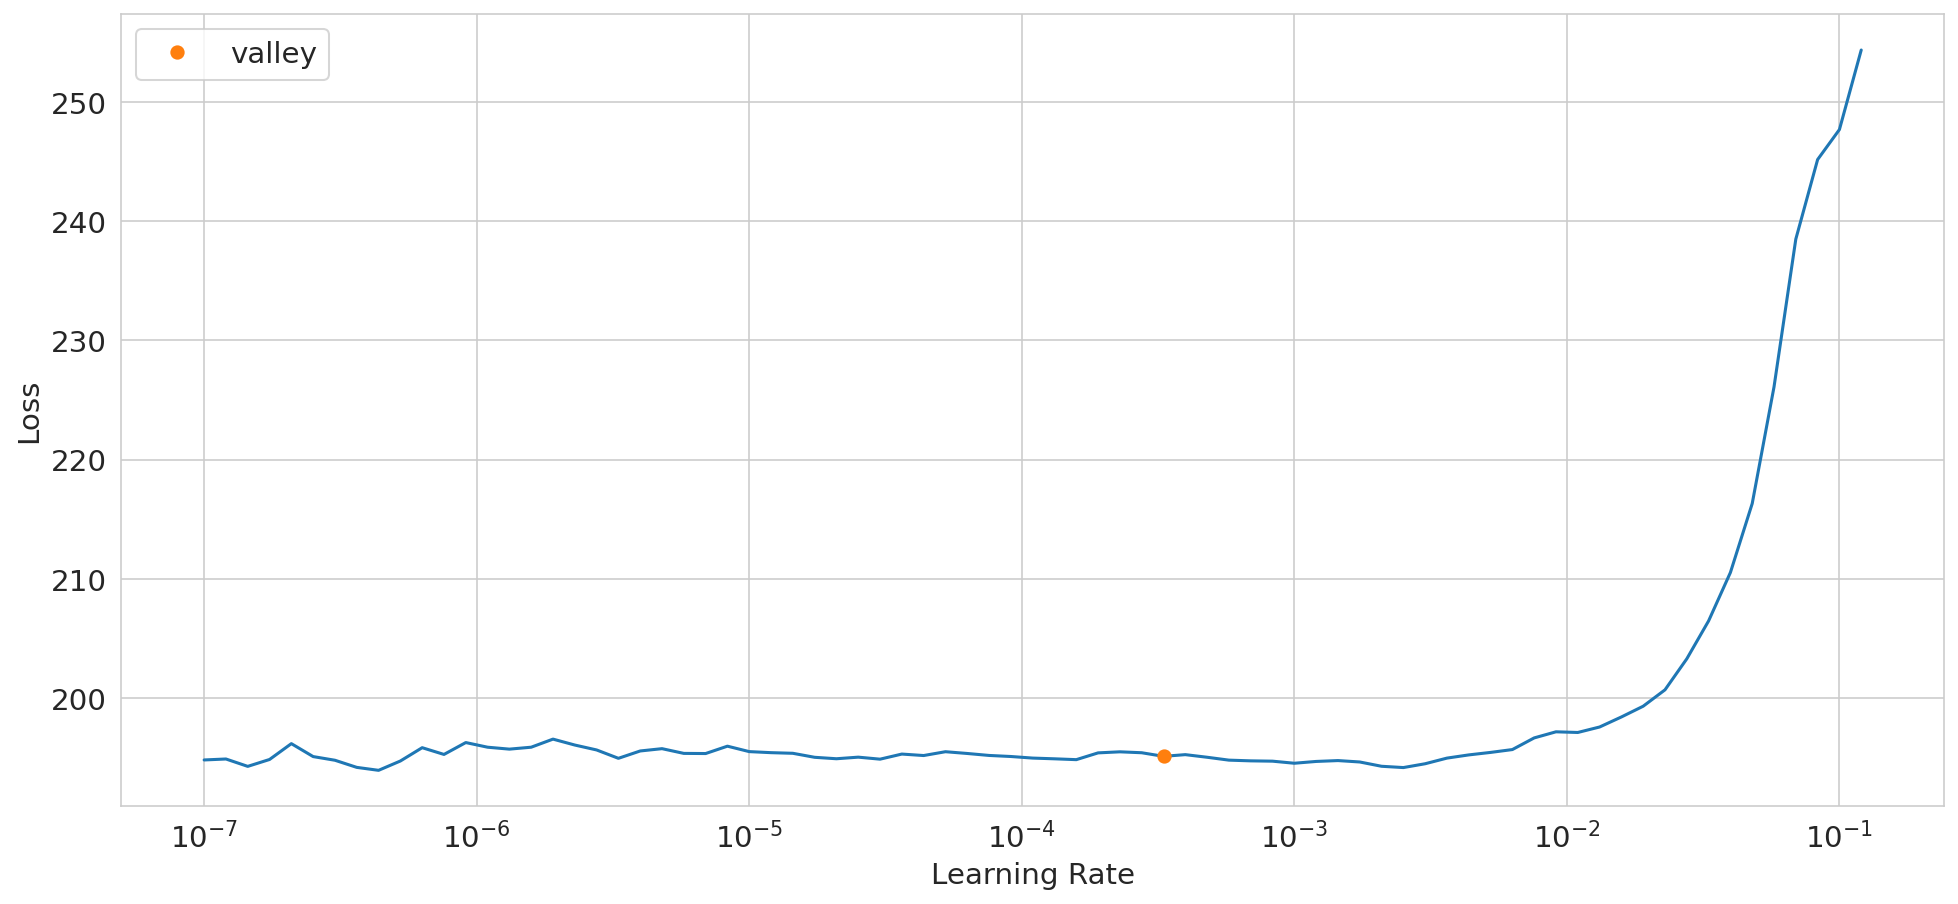

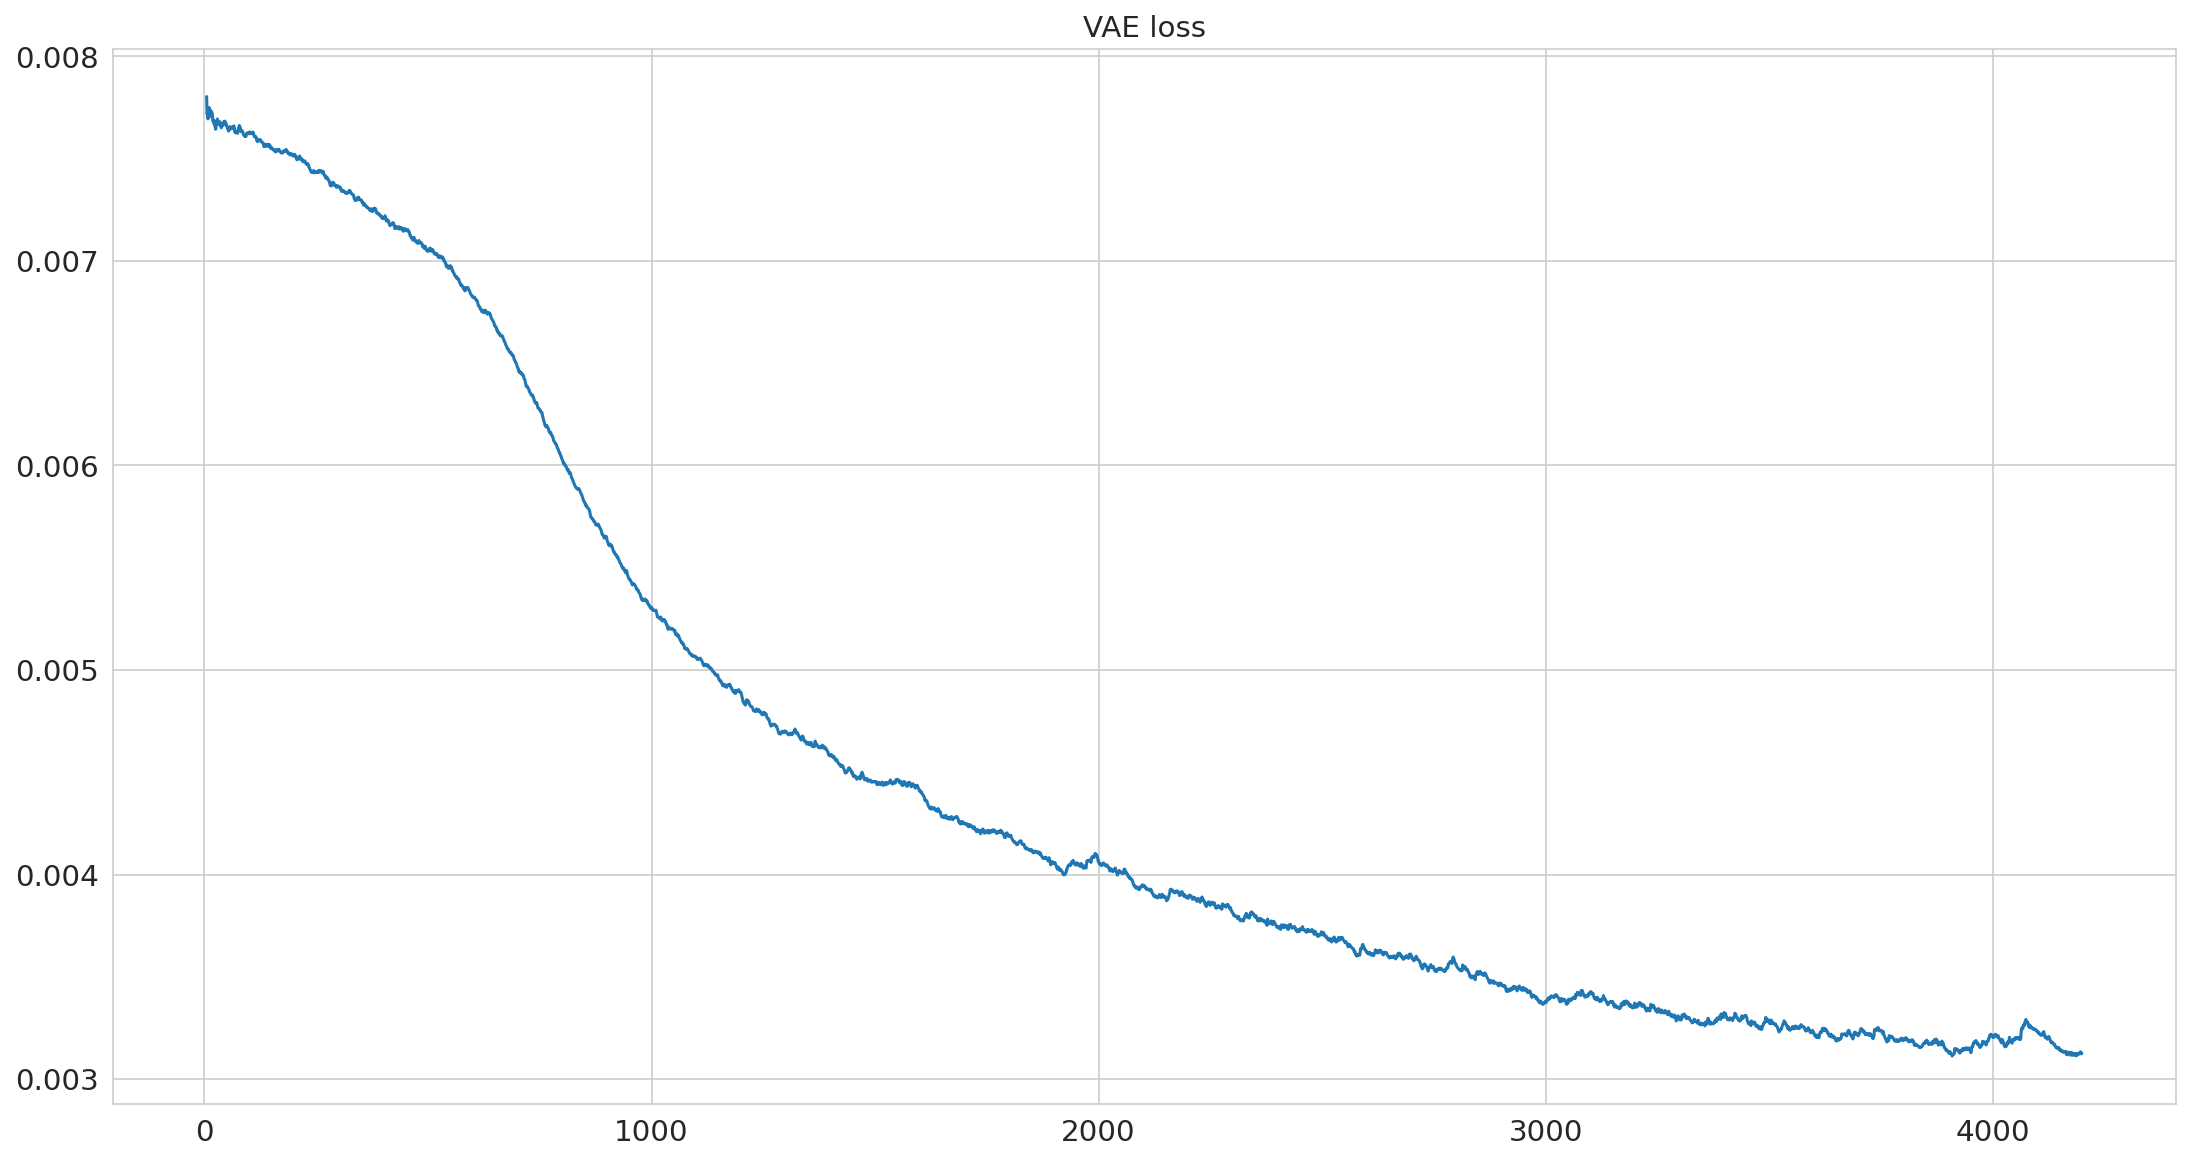

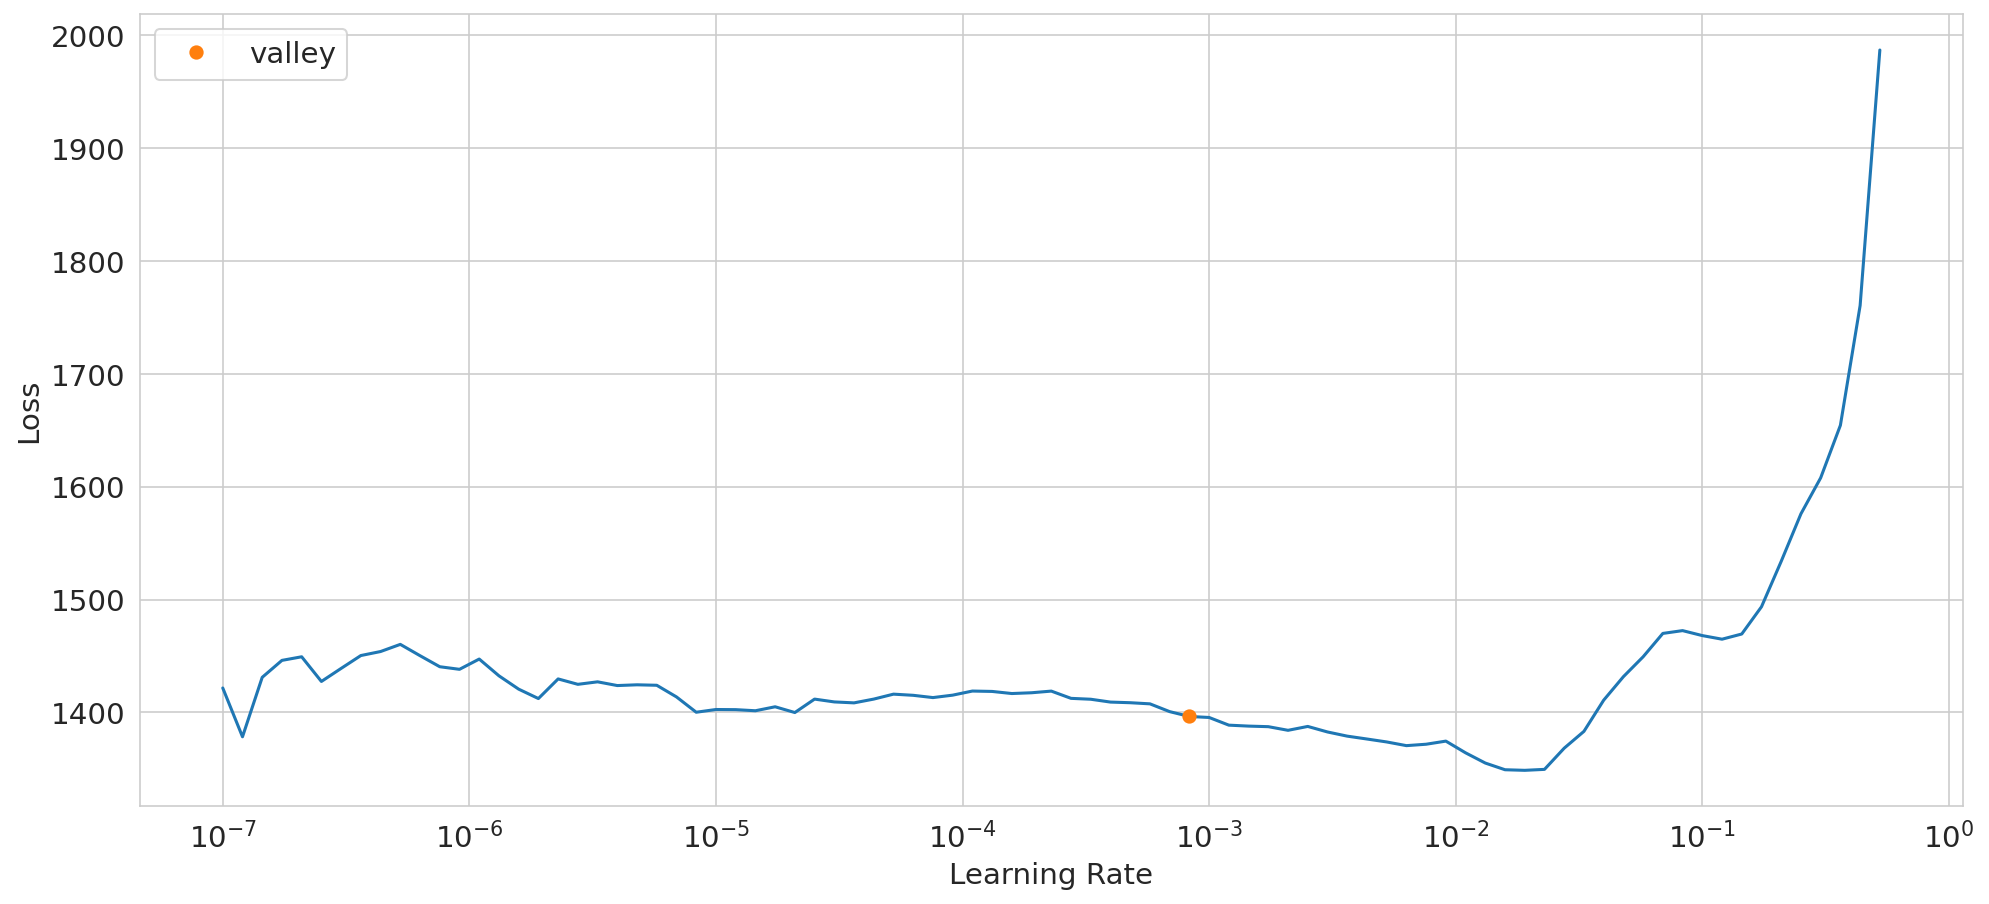

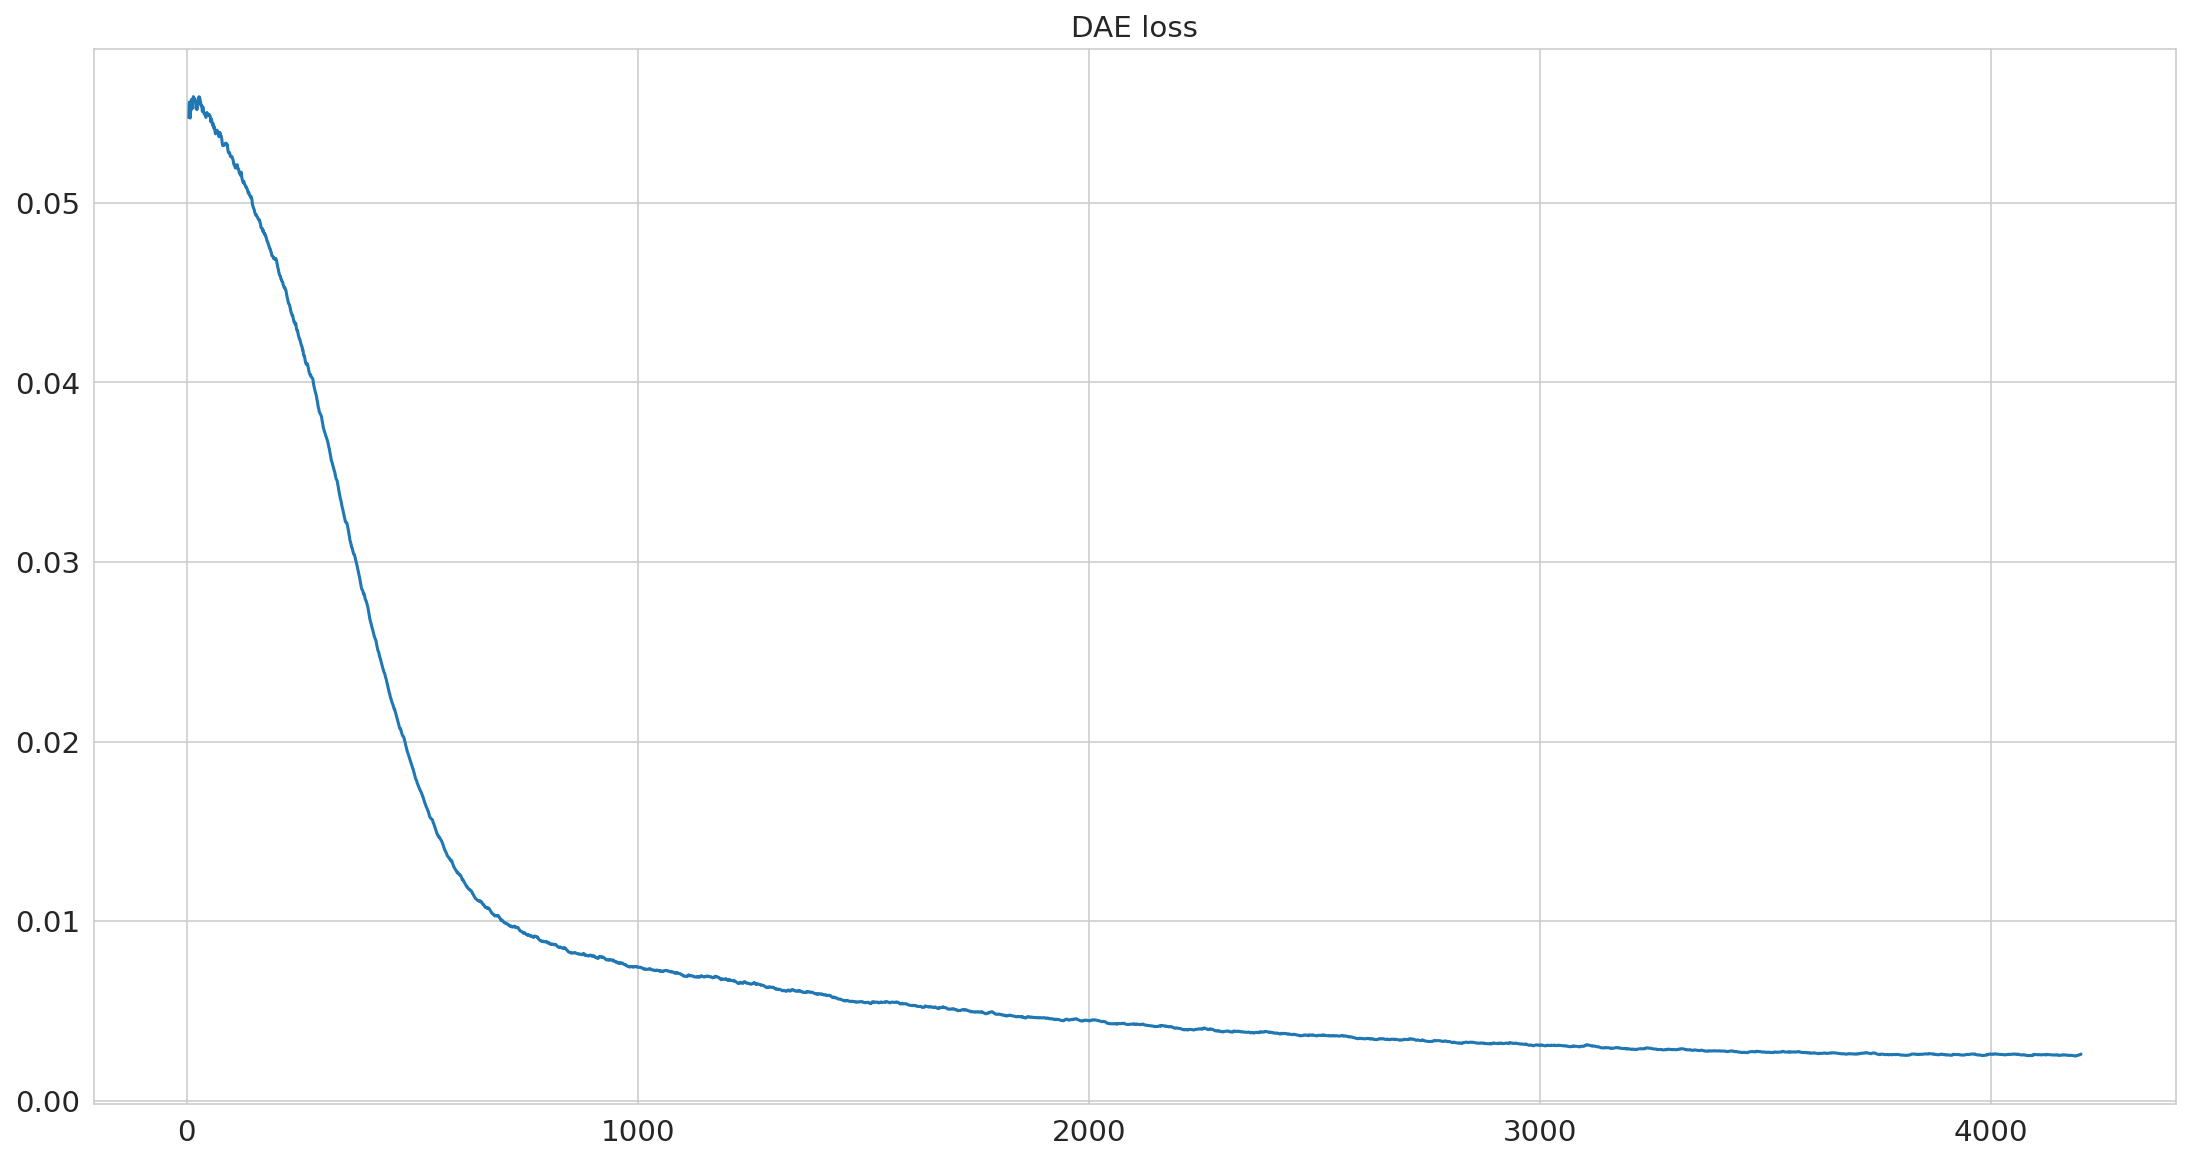

In [7]:
def evaluate_dataset(csv_path, methods, max_epochs=50):
    dataset_name = csv_path.stem
    print(f"\n{'='*60}")
    print(f"Evaluating: {dataset_name}")
    print(f"{'='*60}")
    import tempfile, os
    df = pd.read_csv(csv_path)
    vals = df.iloc[:, 1:].to_numpy(dtype=float)
    pos = vals > 0
    vals[pos] = np.log2(vals[pos])
    df.iloc[:, 1:] = vals

    tmp = tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False)
    try:
        df.to_csv(tmp.name, index=False)
        tmp.close()
        dataset = CSVDataset(tmp.name)
    finally:
        try:
            os.unlink(tmp.name)
        except Exception:
            pass

    data_original = dataset.data_filled.numpy()  
    data_normalized = dataset.data_normalized
    mask = dataset.mask.numpy()

    initial_mask = (data_original != 0) 
    dynamic_mask_bool = (mask == 0) & initial_mask 
    
    print(f"Data shape: {data_original.shape}")
    print(f"Initial observed: {initial_mask.sum()}")
    print(f"Dynamic masked: {dynamic_mask_bool.sum()}")
    print(f"Training observed: {mask.sum()}")
    
    if dynamic_mask_bool.sum() == 0:
        print("Warning: No dynamic mask positions for evaluation!")
        return None

    ground_truth = data_original[dynamic_mask_bool]
    
    results = []

    for method_name, impute_fn in tqdm(methods, desc="Traditional methods"):
        try:
            masked_data = data_original.copy()
            masked_data[mask == 0] = 0  
            zero_cols = (masked_data == 0).all(axis=0)
            n_zero_cols = zero_cols.sum()
            if n_zero_cols > 0:
                print(f"  {method_name}: Warning - {n_zero_cols} all-zero columns detected")
            valid_cols = ~zero_cols
            masked_data_filtered = masked_data[:, valid_cols]
            mask_filtered = mask[:, valid_cols]

            start_time = time.time()

            imputed_filtered = impute_fn(masked_data_filtered, mask_filtered)

            elapsed_time = time.time() - start_time

            imputed = np.zeros_like(data_original)
            imputed[:, valid_cols] = imputed_filtered

            if imputed.shape != data_original.shape:
                print(f"  {method_name} shape mismatch: {imputed.shape} vs {data_original.shape}")
                raise ValueError(f"Shape mismatch: {imputed.shape} != {data_original.shape}")

            predictions = imputed[dynamic_mask_bool]

            test_rows, test_cols = np.where(dynamic_mask_bool)
            valid_test_mask = valid_cols[test_cols] 
            valid_mask = (
                ~np.isnan(ground_truth) & 
                ~np.isnan(predictions) & 
                np.isfinite(predictions) &
                valid_test_mask  
            )
            
            if valid_mask.sum() > 0:
                mse = mean_squared_error(
                    ground_truth[valid_mask],
                    predictions[valid_mask]
                )
            else:
                mse = float('inf')
            
            results.append({
                'dataset': dataset_name,
                'method': method_name,
                'MSE': mse,
                'time_s': elapsed_time,
                'zero_cols': n_zero_cols
            })
            
            print(f"  {method_name}: MSE={mse:.2e}, time={elapsed_time:.2f}s")
            
        except Exception as e:
            print(f"  {method_name} failed: {str(e)[:100]}")
            results.append({
                'dataset': dataset_name,
                'method': method_name,
                'MSE': float('inf'),
                'time_s': 0.0,
                'zero_cols': 0
            })

    for model_name in ['DMF', 'DCAE']:
        try:
            print(f"\nTraining {model_name}...")
            epochs = 500 if model_name == 'DMF' else 2000

            masked_data_check = data_original.copy()
            masked_data_check[mask == 0] = 0
            zero_cols = (masked_data_check == 0).all(axis=0)
            n_zero_cols = zero_cols.sum()
            start_time = time.time()

            imputed_normalized = train_jingwei(
                model_name, 
                data_normalized, 
                torch.tensor(mask, dtype=torch.float32),
                max_epochs=max_epochs
            )

            elapsed_time = time.time() - start_time

            imputed_original = dataset.inverse_transform(imputed_normalized).numpy()

            predictions = imputed_original[dynamic_mask_bool]

            test_rows, test_cols = np.where(dynamic_mask_bool)
            valid_test_mask = (~zero_cols)[test_cols]  
            valid_mask = (
                ~np.isnan(ground_truth) &
                ~np.isnan(predictions) &
                np.isfinite(predictions) &
                valid_test_mask
            )
            if valid_mask.sum() > 0:
                mse = mean_squared_error(
                    ground_truth[valid_mask],
                    predictions[valid_mask]
                )
            else:
                mse = float('inf')
            
            results.append({
                'dataset': dataset_name,
                'method': model_name,
                'MSE': mse,
                'time_s': elapsed_time,
                'zero_cols': n_zero_cols
            })
            
            print(f"  {model_name}: MSE={mse:.2e}, time={elapsed_time:.2f}s, zero_cols={n_zero_cols}")
            
        except Exception as e:
            print(f"  {model_name} failed: {str(e)[:100]}")
            import traceback
            traceback.print_exc()
            results.append({
                'dataset': dataset_name,
                'method': model_name,
                'MSE': float('inf'),
                'time_s': 0.0,
                'zero_cols': 0
            })
    
    return pd.DataFrame(results)

traditional_methods = load_impute_methods()

all_results = []
for csv_file in csv_files: 
    df_result = evaluate_dataset(csv_file, traditional_methods) 
    if df_result is not None:
        all_results.append(df_result)

final_results = pd.concat(all_results, ignore_index=True)

print("\n" + "="*80)
print("BENCHMARK RESULTS")
print("="*80)
display(final_results)

final_results.to_csv("benchmark_results_detailed.csv", index=False)
print("\nResults saved to benchmark_results_detailed.csv")